_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Student name: Marina Dittschar, Clarissa Auckenthaler 

# Coding Lab 4

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy import fft
from scipy.io import loadmat
import math
import oopsi #from Vogelstein et al. (2009)
from oopsi import fast
import matplotlib.patches as mpatches



sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv(r'data\nda_ex_4_ogb_calcium.csv', header=0)  
ogb_spikes = pd.read_csv(r'data\nda_ex_4_ogb_spikes.csv', header=0)  

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv(r'data\nda_ex_4_gcamp2_calcium.csv', header=0)  
gcamp_spikes = pd.read_csv(r'data\nda_ex_4_gcamp2_spikes.csv', header=0)  


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

In [3]:
def decimate_ca(df):
    '''
    Reduce the sampling rate of a dataframe with calcium signal by 4
    
    
    Parameters
    ----------
    df: dataframe
    
    Return
    ------
    df_dec: dataframe    
    '''
    
    # If we directly apply signal.decimate to all columns, every column with at leat one NaN value 
    # gets to all NaN values. To avoid that we used pandas.df.notna(). 

    df_dec= pd.DataFrame()
    for column in df: 
        sig_dec= pd.DataFrame(signal.decimate(df[f'{column}'][df[f'{column}'].notna()],4,axis= 0))
        df_dec= pd.concat([df_dec, sig_dec], axis=1) 
    df_dec= df_dec.set_axis(df.columns, axis=1)
    return df_dec

def decimate_sp(df):
    '''
    
    Reduce the sampling rate of a dataframe with spike signals by 4
    
    Parameters
    ----------
    df: dataframe
    
    Return
    ------
    df_dec: dataframe    
    '''
    
    # If we directly apply signal.decimate to all columns, every column with at leat one NaN value 
    # gets to all NaN values. To avoid that we used pandas.df.notna(). 

    df_dec= pd.DataFrame()
    for column in df: 
        sig_dec= pd.DataFrame(signal.decimate(df[f'{column}'][df[f'{column}'].notna()], 4, axis=0))
        df_dec= pd.concat([df_dec, sig_dec], axis=1) 
    df_dec= df_dec.set_axis(df.columns, axis=1)
    return df_dec

In [4]:
# decimate ogb
ogb_calcium = decimate_ca(ogb_calcium)
ogb_spikes = decimate_sp(ogb_spikes)

# decimate gcamp
gcamp_calcium = decimate_ca(gcamp_calcium)
gcamp_spikes = decimate_sp(gcamp_spikes)

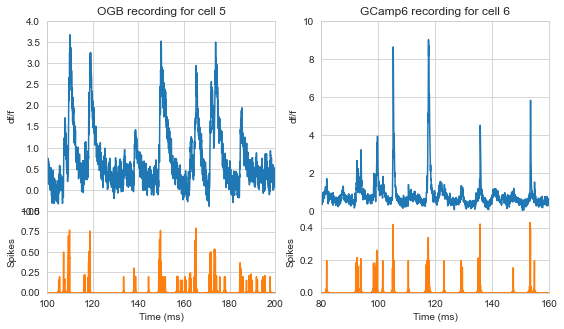

In [5]:
fig = plt.figure(figsize=(9, 5))
time_g = np.arange(100,200, .04)
time_c=  np.arange (80,160, .04)

# ----------------------------
# Plot raw calcium data (1 pt)
# ----------------------------


# --------------------------
# Plot raw spike data (1 pt)
# --------------------------
 
gs = fig.add_gridspec(2,2, height_ratios=[.7,.3] ,hspace=0)


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
ax1.plot(time_g, ogb_calcium["4"][2500:5000])
ax2.plot(time_g, ogb_spikes["4"][2500:5000], color="#ff7f0e")
ax3.plot(time_c, gcamp_calcium["5"][2000:4000])
ax1.set_ylim(-.5,4)
ax4.plot(time_c,gcamp_spikes["5"][2000:4000], color="#ff7f0e")

ax1.set_ylabel("df/f")
ax2.set_ylabel("Spikes")
ax3.set_ylabel("df/f")
ax4.set_ylabel("Spikes")

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

ax2.set_ylim(0,1)
ax3.set_ylim(0, 10)
ax4.set_ylim(0, .5)

ax1.set_xlim(100,200)
ax2.set_xlim(100,200)
ax3.set_xlim(80,160)
ax4.set_xlim(80,160)


ax2.set_xlabel("Time (s)")
ax4.set_xlabel("Time (s)")
ax1.set_title("OGB recording for cell 5")
ax3.set_title("GCamp6 recording for cell 6")


plt.show()

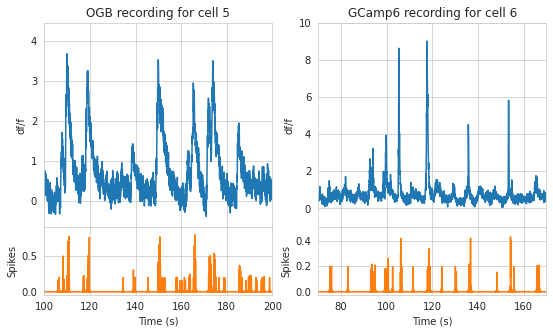

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons.

*Grading: 3 pts*


In [6]:
def deconv_ca(ca, tau, dt):
    '''Deconvolute a calcium signal with a decay kernel 
    
    Parameters
    ----------
    
    ca: np.array, (n_points,)
        Calcium trace
    
    tau: float
        decay constant of conv kernel
    
    dt: float
        sampling interval.
    
    Return
    ------
    
    sp_hat: np.array    
    '''
    
    time = np.arange(start=0,stop=3, step=.05)
    kernel = math.e**(-time/tau)
    
    # cutoff frequency derived from "Reconstruction of firing rate changes across 
    #neuronal populations by temporally deconvolved Ca2+ imaging",Yaksi & Friedrich, 2006
    # Cutoff-frequency = 0.2 * framerate = 0.2 * 25 = 5
    
    #filtparams = filtparams = butter(N=5, Wn = 5, fs= 1/dt, btype="lowpass")
    #ca= filtfilt(*filtparams,ca)
    
    sp_hat, remainder = signal.deconvolve(ca, kernel)
    sp_hat = np.clip(sp_hat, 0, None)

    return sp_hat, remainder

<Figure size 432x360 with 0 Axes>

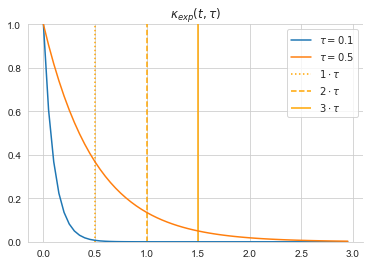

In [7]:
plt.figure(figsize=(6,5))

# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
fig, ax = plt.subplots(1,1)
# decay constants
tau_ogb = .5
tau_gcamp = .1
# define kernel decay over time
time = np.arange(start=0,stop=3, step=.05)
kernel5 = math.e**(-time/tau_ogb)
kernel1 = math.e**(-time/tau_gcamp)

# plot kernels
ax.plot(time,kernel1, label = r"$\tau = 0.1$")
ax.plot(time,kernel5, label = r"$\tau = 0.5$")

ax.vlines(tau_ogb, 0, 1.1, color="orange", linestyle=":",  label=r"$1 \cdot \tau$ ")
ax.vlines(tau_ogb*2, 0, 1.1, color="orange", linestyle="--", label=r"$2\cdot \tau$ ")
ax.vlines(tau_ogb*3, 0, 1.1, color="orange", label=r"$3\cdot \tau$ ")
ax.legend()
ax.set_ylim(0,1.)
ax.set_title(r"$\kappa_{exp}(t,\tau)$")

sns.despine()

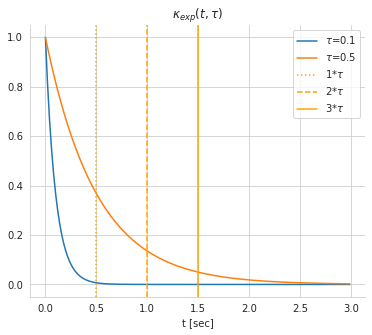

In [8]:
# --------------------------------------------
# apply devonvolution to calcium signal (1 pt)
# --------------------------------------------
ogb_conv, ogb_remainder = deconv_ca(ogb_calcium['4'], kernel5, .04)

gcamp_conv, gcamp_remainder= deconv_ca(gcamp_calcium['5'], kernel1, .04)

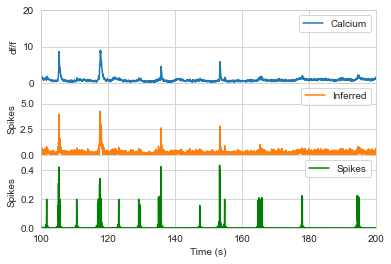

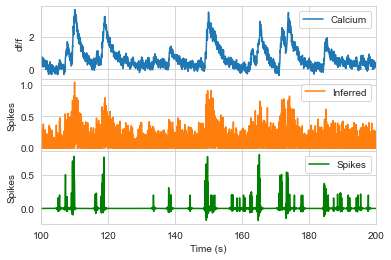

In [9]:
fig = plt.figure(figsize=(6,4))

# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------
 
time = np.arange(100,200, .04)
gs = fig.add_gridspec(3,1,hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(time,gcamp_calcium['5'][2500:5000], label="Calcium")
ax0.set_ylabel("df/f")
ax0.set_ylim(0,20)
ax0.set_xlim(100,200)

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(time,gcamp_conv[2500:5000], color='#ff7f0e', label="Inferred")
ax1.set_ylabel("Spikes")
ax1.set_ylim(0,7)
ax1.set_xlim(100, 200)

ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(time,gcamp_spikes['5'][2500:5000], color="green", label="Spikes")
ax2.set_ylabel("Spikes")
ax2.set_ylim(0,.5)
ax2.set_xlim(100,200)

ax2.set_xlabel("Time (s)")
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
ax0.legend()
ax1.legend()
ax2.legend()

fig = plt.figure(figsize=(6,4))
 
gs = fig.add_gridspec(3,1,hspace=0)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(time,ogb_calcium['4'][2500:5000], label="Calcium")
ax0.set_ylabel("df/f")
ax0.set_xlim(100,200)

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(time,ogb_conv[2500:5000], color='#ff7f0e', label="Inferred")
ax1.set_ylabel("Spikes")
ax1.set_xlim(100,200)

ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(time,ogb_spikes['4'][2500:5000], color="green", label="Spikes")
ax2.set_ylabel("Spikes")
ax2.set_xlim(100,200)

ax2.set_xlabel("Time (s)")

ax0.legend()
ax1.legend()
ax2.legend()

plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.show()


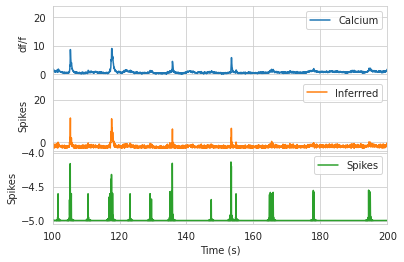

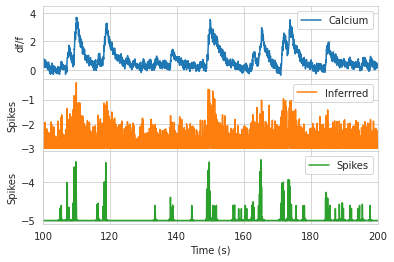

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [10]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)
# -------------------------------------------------------------- 
ogb_d, ogb_Cz = oopsi.fast(ogb_calcium["4"], dt=0.04, iter_max=6)

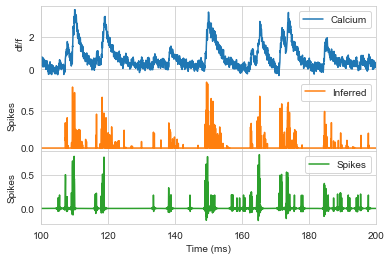

In [11]:
fig = plt.figure(figsize=(6,4))

# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
#---------------------------------------------

gs4 = fig.add_gridspec(3,1, height_ratios=[.3,.3,.3] ,hspace=0)

ax1 = fig.add_subplot(gs4[0, 0])
ax2 = fig.add_subplot(gs4[1, 0])
ax3 = fig.add_subplot(gs4[2, 0])

ax1.plot(time_g, ogb_calcium["4"][2500:5000], color= 'tab:blue', label= "Calcium")
ax2.plot(time_g, ogb_d[2500:5000],color='tab:orange', label= "Inferred" )
ax3.plot(time_g, ogb_spikes["4"][2500:5000], 'tab:green',  label= "Spikes")
ax1.set_ylabel("df/f")

ax2.set_ylabel("Spikes")
ax3.set_ylabel("Spikes")
ax3.set_xlabel("Time (ms)")

ax1.set_xlim(100,200)
ax2.set_xlim(100,200)
ax3.set_xlim(100,200)

ax1.legend()
ax2.legend()
ax3.legend()

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.show()

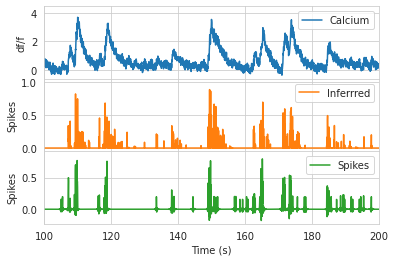

In [12]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------
GCamP_d, GCamP_Cz = oopsi.fast(gcamp_calcium["5"], dt=0.04, iter_max=6)

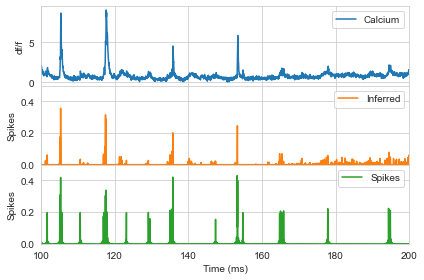

In [13]:
fig = plt.figure(figsize=(6,4))

# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------

gs4 = fig.add_gridspec(3,1, height_ratios=[.3,.3,.3] ,hspace=0)

ax1 = fig.add_subplot(gs4[0, 0])
ax2 = fig.add_subplot(gs4[1, 0])
ax3 = fig.add_subplot(gs4[2, 0])

ax1.plot(time_g, gcamp_calcium["5"][2500:5000], color="tab:blue", label= "Calcium")
ax2.plot(time_g, GCamP_d[2500:5000],color= 'tab:orange',  label= "Inferred")
ax3.plot(time_g, gcamp_spikes["5"][2500:5000], color= 'tab:green',  label= "Spikes")


ax1.set_xlim(100,200)
ax2.set_xlim(100,200)
ax3.set_xlim(100,200)


ax2.set_ylim(0,.5)
ax3.set_ylim(0,.5)

ax1.set_ylabel("df/f")
ax2.set_ylabel("Spikes")
ax3.set_ylabel("Spikes")




ax3.set_xlabel("Time (ms)")

ax1.legend()
ax2.legend()
ax3.legend()

plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.tight_layout()
plt.show()

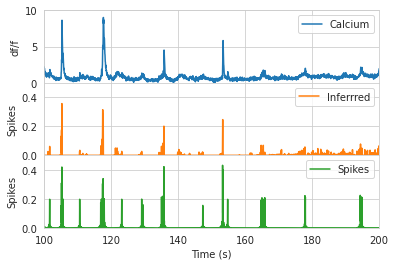

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [14]:
def get_cors(signal, spikes, kernel):
    """
    Get the correlation coefficients of inferred signals and true spike trains with 
    the oopsi algorithm and a simple deconvolution algorithm
    
    Parameters
    ----------
    
    signal: pd.DataFrame (n_samples, n_cells,)
    Dataframe of calcium signals
    
    spikes: pd:DataFrame (n_samples, n_cells,)
    Dataframe of true spike trains
    
    kernel: np.array
    Array of decay for cells
    
    Returns
    -------
    
    oopsi_cors: np.array (n_cells,)
    correlation coefficients of oopsi-derived spikes and true spikes
    
    conv_cors: np.array (n_cells,)
    correlation coefficients of deconvolution-derived spikes and true spikes
    """
    oopsi_cors = []
    conv_cors = []

    for column in signal: 
        signal_d, signal_Cz = oopsi.fast(signal[column][signal[column].notna()], dt=0.04, iter_max=6)
        spike_ref = spikes[column][signal[column].notna()].to_numpy()
        oopsi_cor = np.corrcoef(signal_d, spike_ref)[0,1]
        oopsi_cors = np.append(oopsi_cors, oopsi_cor)

        signal_conv, remainder = deconv_ca(signal[column][signal[column].notna()], kernel, .04)
        remainder_len = spike_ref.shape[0] -signal_conv.shape[0]
        # deconvolved signal is shorter than original - only compute correlation coefficient on 
        # truncated original signal
        signal_rem = np.append(signal_conv, remainder[-remainder_len:])
        conv_cor = np.corrcoef(signal_rem, spike_ref)[0,1]
        conv_cors = np.append(conv_cors, conv_cor)
        
    return oopsi_cors, conv_cors

def get_df(oopsi_cors, conv_cors, ind_name):
    """
    Return a dataframe with correlation coefficients and indicator name
    
    Parameters
    ----------
    
    oopsi_cors: np.array (n_cells,)
    correlation coefficients of oopsi-derived spikes and true spikes
    
    conv_cors: np.array (n_cells,)
    correlation coefficients of deconvolution-derived spikes and true spikes
    
    ind_name: string
    name of indicator
    
    """
        
    corr_df = pd.DataFrame()
    no_col_oopsi = len(oopsi_cors)
    corr_df["Correlation"] = oopsi_cors
    corr_df["Algorithm"] = np.tile(["oopsi"], (no_col_oopsi,))
    corr_df["Indicator"] = np.tile([ind_name], (no_col_oopsi,))
    
    no_col_conv = len(conv_cors)
    conv_df = pd.DataFrame()
    conv_df["Correlation"] = conv_cors
    conv_df["Algorithm"] = np.tile(["deconv"], (no_col_conv,))
    conv_df["Indicator"] = np.tile([ind_name], (no_col_conv,))
    
    all_df = pd.concat([corr_df, conv_df])
        
    return all_df
        



In [15]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------

oopsi_ogb, conv_ogb = get_cors(ogb_calcium, ogb_spikes, kernel5)
ogb_corr_df = get_df(oopsi_ogb, conv_ogb, "ogb")

Create OGB dataframe

Evaluate on GCamp data

In [16]:
# ---------------------------------------------------
# Create dataframe for GCamP Cell as described (1 pt)
# ---------------------------------------------------
oopsi_gcamp, conv_gcamp = get_cors(gcamp_calcium, gcamp_spikes, kernel1)

Create GCamp dataframe

In [17]:
gcamp_corr_df = get_df(oopsi_gcamp, conv_gcamp, "gcamp")

Combine both dataframes and plot

In [18]:
corr_df = pd.concat([ogb_corr_df, gcamp_corr_df])
oopsi_cors = ogb_corr_df["Correlation"][ogb_corr_df["Indicator"] == "ogb"][ogb_corr_df["Algorithm"] == "oopsi"]
conv_cors = ogb_corr_df["Correlation"][ogb_corr_df["Indicator"] == "ogb"][ogb_corr_df["Algorithm"] == "deconv"]
gcamp_oopsi_cors = gcamp_corr_df["Correlation"][gcamp_corr_df["Indicator"] == "gcamp"][gcamp_corr_df["Algorithm"] == "oopsi"]
gcamp_conv_cors = gcamp_corr_df["Correlation"][gcamp_corr_df["Indicator"] == "gcamp"][gcamp_corr_df["Algorithm"] == "deconv"]

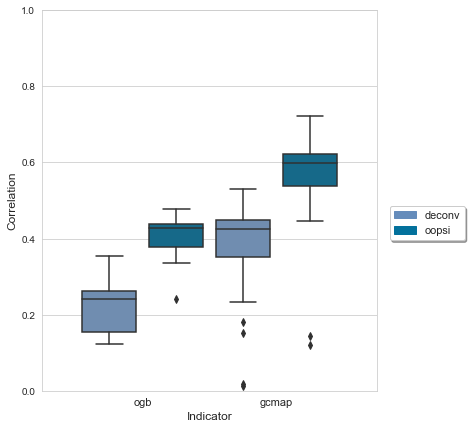

In [19]:
plt.figure(figsize=(6,7))
# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# ---------------------------------------------------------------------------
boxplot = sns.boxplot(
    data=[conv_cors, oopsi_cors, gcamp_conv_cors, gcamp_oopsi_cors],
    palette=[sns.xkcd_rgb["faded blue"], sns.xkcd_rgb["ocean blue"], sns.xkcd_rgb["faded blue"], sns.xkcd_rgb["ocean blue"]],
      
)
boxplot.set_ylim(0,1)
boxplot.set_xlim (-1,4)
boxplot.set_xticks([0.5, 2.5])
boxplot.set_xticklabels(["ogb", "gcmap"],fontsize= 11)
boxplot.set_ylabel("Correlation", fontsize= 12)
boxplot.set_xlabel("Indicator", fontsize = 12)

conv_leg = mpatches.Patch(color= sns.xkcd_rgb["faded blue"], label='deconv')
oopsi_leg = mpatches.Patch(color= sns.xkcd_rgb["ocean blue"], label='oopsi')
plt.legend(handles= [conv_leg,oopsi_leg],loc='upper center', bbox_to_anchor=(1.15, 0.5), shadow=True, ncol=1, fontsize= 11)

plt.show()

We can see that the oopsi algorithm generally performs better than the simple deconvolution algorithm, both on the ogb and the GCamp cells. Performance is better on the GCamp cells for both algorithms. For analysis, the oopsi-algorithm should be preferred over the simpler model.

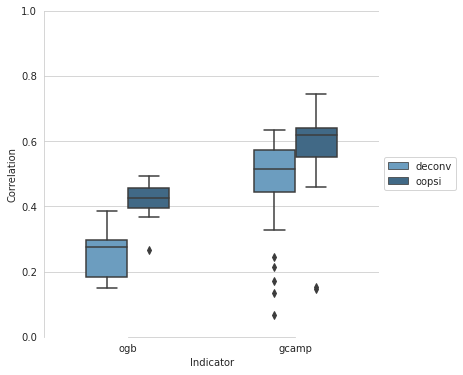

Citations: 
https://github.com/liubenyuan/py-oopsi

Yaksi & Friedrich, "Reconstruction of firing rate changes across neuronal populations by temporally deconvolved Ca2+ imaging", (2006)

Joshua T Vogelstein, Adam M Packer, Tim A Machado, Tanya Sippy, Baktash Babadi, Rafael Yuste, Liam Paninski [Fast non-negative deconvolution for spike train inference from population calcium imaging] (http://stat.columbia.edu/~liam/research/pubs/vogelstein-fast.pdf) Journal of Neurophysiology, 104(6): 3691-3704